# Scenario Analysis

The objective of this notebook is threefold:

1. To determine an appropriate number of scenarios that capture the full range of possible outcomes (repeating simulation)
2. To analyze the nature of uncertainties within the project and how they affect the outcomes (sensitivity analysis)
3. To identify interesting scenarios to use in direct policy search (scenario discovery)

## 0 Setup

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## 1 Repeating Simulation within Uncertainty Space

This section aims to determine the appropriate number of scenarios needed to sufficiently cover the uncertainty space. By varying the number of scenarios and running simulations multiple times, we can assess how the distribution of key outcomes changes as the sample size increases. The goal is to identify a scenario count that captures the full range of possible outcomes without excessive computational cost. This ensures robust analysis while maintaining computational efficiency.

### Run simulation

This section runs the simulation experiments. Before executing, ensure you have set the problem formulation (`pf`), number of scenarios (`n_scenario`), number of policies (`n_policy`), and the sampling technique. The code will generate two sets of simulation results for the specified settings. To analyze different scenario counts (as done in this notebook), update the settings and rerun this cell as needed. If you already have the simulation results saved, you can skip this step and proceed directly to the section for loading results from disk.

In [2]:
######## Problem Formulation
pf = 6
n_scenario = 2**6
n_policy = 1
sampling_technique = Samplers.SOBOL

######## Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

######## Reference Policy (No Levers)
ref_policy = [Policy('policy 1', **{'0_RfR 0':0,
                                    '1_RfR 0':0,
                                    '2_RfR 0':0,
                                    '3_RfR 0':0,
                                    '4_RfR 0':0,
                                    '0_RfR 1':0,
                                    '1_RfR 1':0,
                                    '2_RfR 1':0,
                                    '3_RfR 1':0,
                                    '4_RfR 1':0,
                                    'A.1_DikeIncrease 0':0,
                                    'A.2_DikeIncrease 0':0,
                                    'A.3_DikeIncrease 0':0,
                                    'A.4_DikeIncrease 0':0,
                                    'A.5_DikeIncrease 0':0,
                                    'A.1_DikeIncrease 1':0,
                                    'A.2_DikeIncrease 1':0,
                                    'A.3_DikeIncrease 1':0,
                                    'A.4_DikeIncrease 1':0,
                                    'A.5_DikeIncrease 1':0,
                                    'EWS_DaysToThreat':0})
                                ]

In [ ]:
######## Run Model
# Run and save results for two different random seeds (suffix 1 and 2)
for suffix in [1, 2]:
    ema_logging.log_to_stderr(ema_logging.INFO)
    with MultiprocessingEvaluator(model, n_processes=6) as evaluator:
        results = evaluator.perform_experiments(scenarios=n_scenario, policies=ref_policy, uncertainty_sampling=sampling_technique)
    save_results(results, f'results/data/GSA_PF{pf}_S{n_scenario}_P{n_policy}_{sampling_technique.name}_{suffix}.tar.gz')

### Load run results

In [3]:
# Load Results

# run 1
pf_1 = 6
n_scenario_1 = 2**12
n_policy_1 = 1
sampling_technique_1 = Samplers.SOBOL
suffix_1 = 1
results_1 = load_results(f'results/data/GSA_PF{pf_1}_S{n_scenario_1}_P{n_policy_1}_{sampling_technique_1.name}_{suffix_1}.tar.gz')

# run 2
pf_2= 6
n_scenario_2 = 2**10
n_policy_2 = 1
sampling_technique_2 = Samplers.SOBOL
suffix_2 = 1
results_2 = load_results(f'results/data/GSA_PF{pf_2}_S{n_scenario_2}_P{n_policy_2}_{sampling_technique_2.name}_{suffix_2}.tar.gz')

# run 3
pf_3 = 6
n_scenario_3 = 2**8
n_policy_3 = 1
sampling_technique_3 = Samplers.SOBOL
suffix_3a = 1
results_3a = load_results(f'results/data/GSA_PF{pf_3}_S{n_scenario_3}_P{n_policy_3}_{sampling_technique_3.name}_{suffix_3a}.tar.gz')

# run 3a
pf_3 = 6
n_scenario_3 = 2**8
n_policy_3 = 1
sampling_technique_3 = Samplers.SOBOL
suffix_3 = 2
results_3 = load_results(f'results/data/GSA_PF{pf_3}_S{n_scenario_3}_P{n_policy_3}_{sampling_technique_3.name}_{suffix_3}.tar.gz')

# run 4
pf_4 = 6
n_scenario_4 = 2**6
n_policy_4 = 1
sampling_technique_4 = Samplers.SOBOL
suffix_4 = 2
results_4 = load_results(f'results/data/GSA_PF{pf_4}_S{n_scenario_4}_P{n_policy_4}_{sampling_technique_4.name}_{suffix_4}.tar.gz')

# run 4a
pf_4 = 6
n_scenario_4 = 2**6
n_policy_4 = 1
sampling_technique_4 = Samplers.SOBOL
suffix_4a = 2
results_4a = load_results(f'results/data/GSA_PF{pf_4}_S{n_scenario_4}_P{n_policy_4}_{sampling_technique_4.name}_{suffix_4a}.tar.gz')

# run 5
pf_5 = 6
n_scenario_5 = 2**5
n_policy_5 = 1
sampling_technique_5 = Samplers.SOBOL
suffix_5 = 2
results_5 = load_results(f'results/data/GSA_PF{pf_5}_S{n_scenario_5}_P{n_policy_5}_{sampling_technique_5.name}_{suffix_5}.tar.gz')

# run 6
pf_6 = 6
n_scenario_6 = 2**3
n_policy_6 = 1
sampling_technique_6 = Samplers.SOBOL
suffix_6 = 2
results_6 = load_results(f'results/data/GSA_PF{pf_6}_S{n_scenario_6}_P{n_policy_6}_{sampling_technique_6.name}_{suffix_6}.tar.gz')

experiments_1, outcomes_1 = results_1
experiments_2, outcomes_2 = results_2
experiments_3, outcomes_3 = results_3
experiments_3a, outcomes_3a = results_3a
experiments_4, outcomes_4 = results_4
experiments_4a, outcomes_4a = results_4a
experiments_5, outcomes_5 = results_5
experiments_6, outcomes_6 = results_6

# print shape of experiments and outcomes
print(f'Experiments 1 shape: {experiments_1.shape}')
print(f'Experiments 2 shape: {experiments_2.shape}')
print(f'Experiments 3 shape: {experiments_3.shape}')
print(f'Experiments 3a shape: {experiments_3a.shape}')
print(f'Experiments 4 shape: {experiments_4.shape}')
print(f'Experiments 4a shape: {experiments_4a.shape}')
print(f'Experiments 5 shape: {experiments_5.shape}')
print(f'Experiments 6 shape: {experiments_6.shape}')

[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S4096_P1_SOBOL_1.tar.gz
[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S1024_P1_SOBOL_1.tar.gz
[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S256_P1_SOBOL_1.tar.gz
[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S256_P1_SOBOL_2.tar.gz
[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S64_P1_SOBOL_2.tar.gz
[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S64_P1_SOBOL_2

Experiments 1 shape: (155648, 42)
Experiments 2 shape: (38912, 42)
Experiments 3 shape: (9728, 42)
Experiments 3a shape: (9728, 42)
Experiments 4 shape: (2432, 42)
Experiments 4a shape: (2432, 42)
Experiments 5 shape: (1216, 42)
Experiments 6 shape: (304, 42)


### Compare distribution of key outcomes

We visualize the distribution of key outcomes—such as Expected Annual Damage, Expected Number of Deaths, and Total Costs—across multiple simulation runs, each with a different number of scenarios. By plotting histograms for each outcome and dike, we can assess how the shape and spread of the distributions change as the sample size increases. This approach helps us determine the minimum number of scenarios required to reliably capture the full range of possible outcomes, ensuring that our analysis is both robust and computationally efficient.

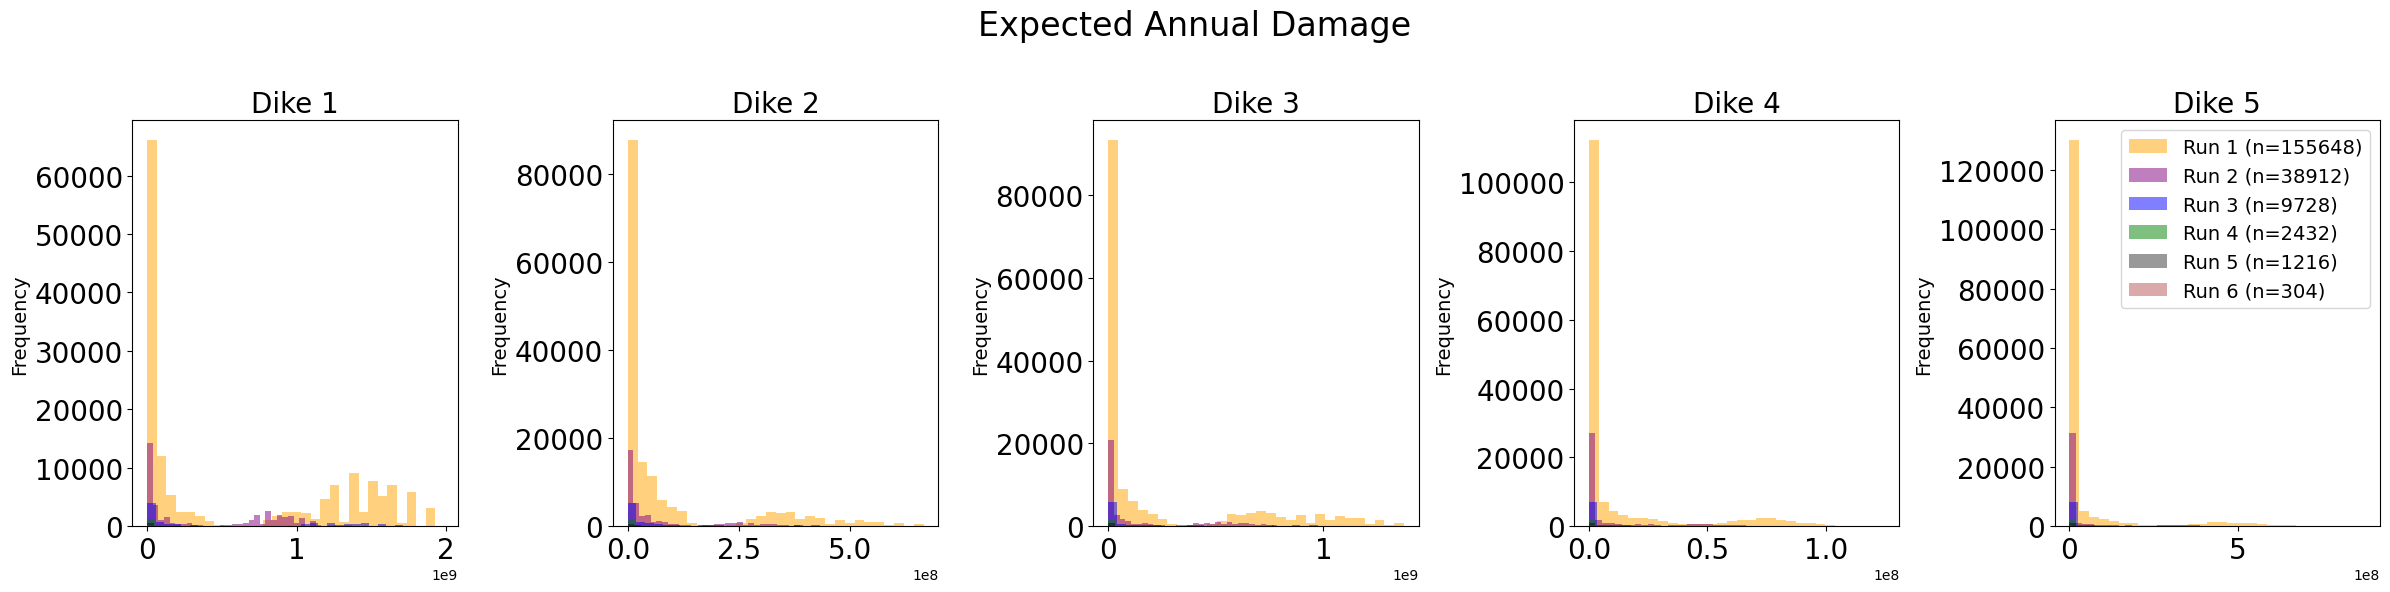

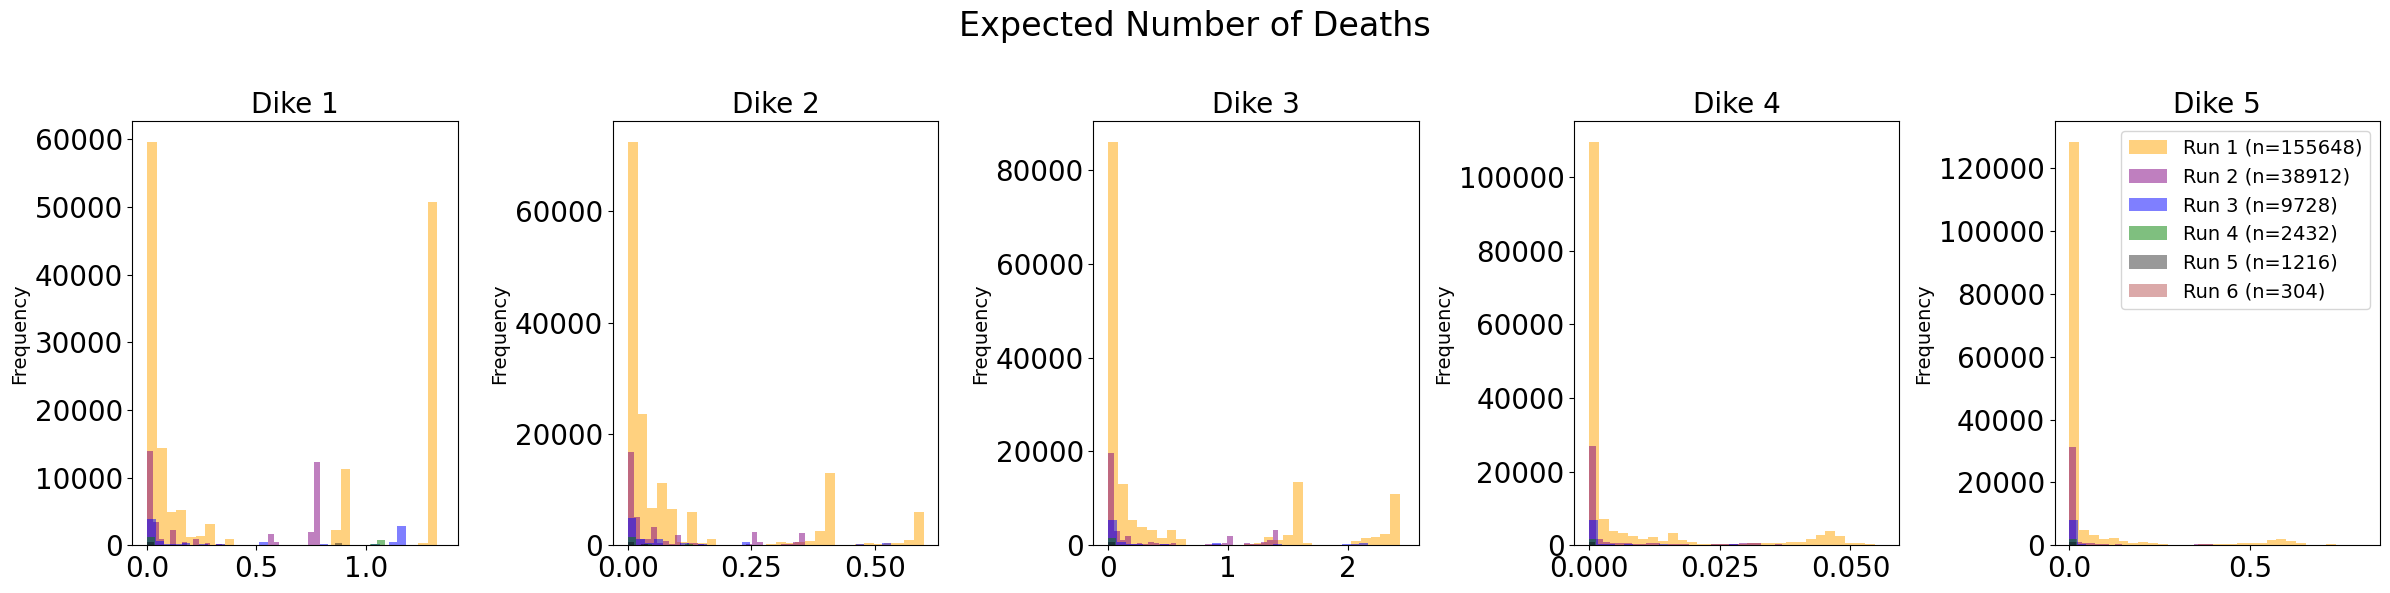

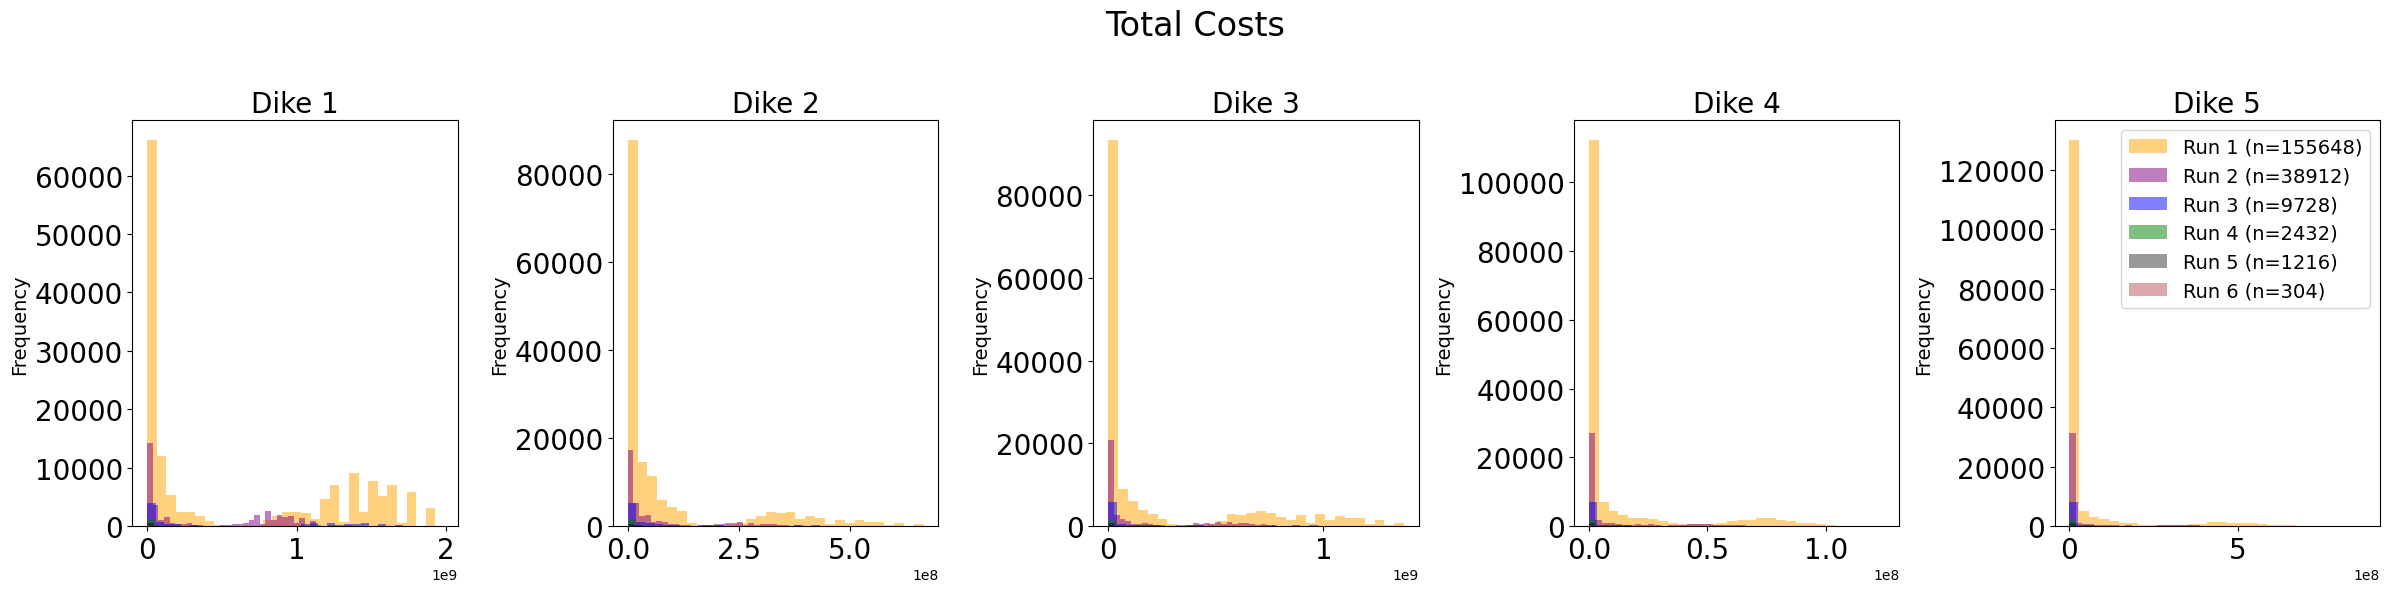

Figure 1: Histograms of disaggregated outcomes for all dikes, comparing 6 runs, in normal scale.


In [4]:
## Histogram plot - normal scale

disaggregated_outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs"]

# Plot histograms for each disaggregated outcome for all dikes, comparing two runs
for outcome_name in disaggregated_outcome_names:
    fig, axes = plt.subplots(1, 5, figsize=(24, 6))
    for i, dike_no in enumerate(range(1, 6)):
        key = f"A.{dike_no}_{outcome_name}"
        axes[i].hist(outcomes_1[key], bins=30, color='orange', edgecolor='none', alpha=0.5, label=f'Run 1 (n={experiments_1.shape[0]})')
        axes[i].hist(outcomes_2[key], bins=30, color='purple', edgecolor='none', alpha=0.5, label=f'Run 2 (n={experiments_2.shape[0]})')
        axes[i].hist(outcomes_3[key], bins=30, color='blue', edgecolor='none', alpha=0.5, label=f'Run 3 (n={experiments_3.shape[0]})')
        axes[i].hist(outcomes_4[key], bins=30, color='green', edgecolor='none', alpha=0.5, label=f'Run 4 (n={experiments_4.shape[0]})')
        axes[i].hist(outcomes_5[key], bins=30, color='black', edgecolor='none', alpha=0.4, label=f'Run 5 (n={experiments_5.shape[0]})')
        axes[i].hist(outcomes_6[key], bins=30, color='brown', edgecolor='none', alpha=0.4, label=f'Run 6 (n={experiments_6.shape[0]})')
        axes[i].set_title(f"Dike {dike_no}", fontsize=20)
        axes[i].set_ylabel("Frequency", fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=20)
        if i == 4:
            axes[i].legend(fontsize=14)
    fig.suptitle(f"{outcome_name}", fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("Figure 1: Histograms of disaggregated outcomes for all dikes, comparing 6 runs, in normal scale.")

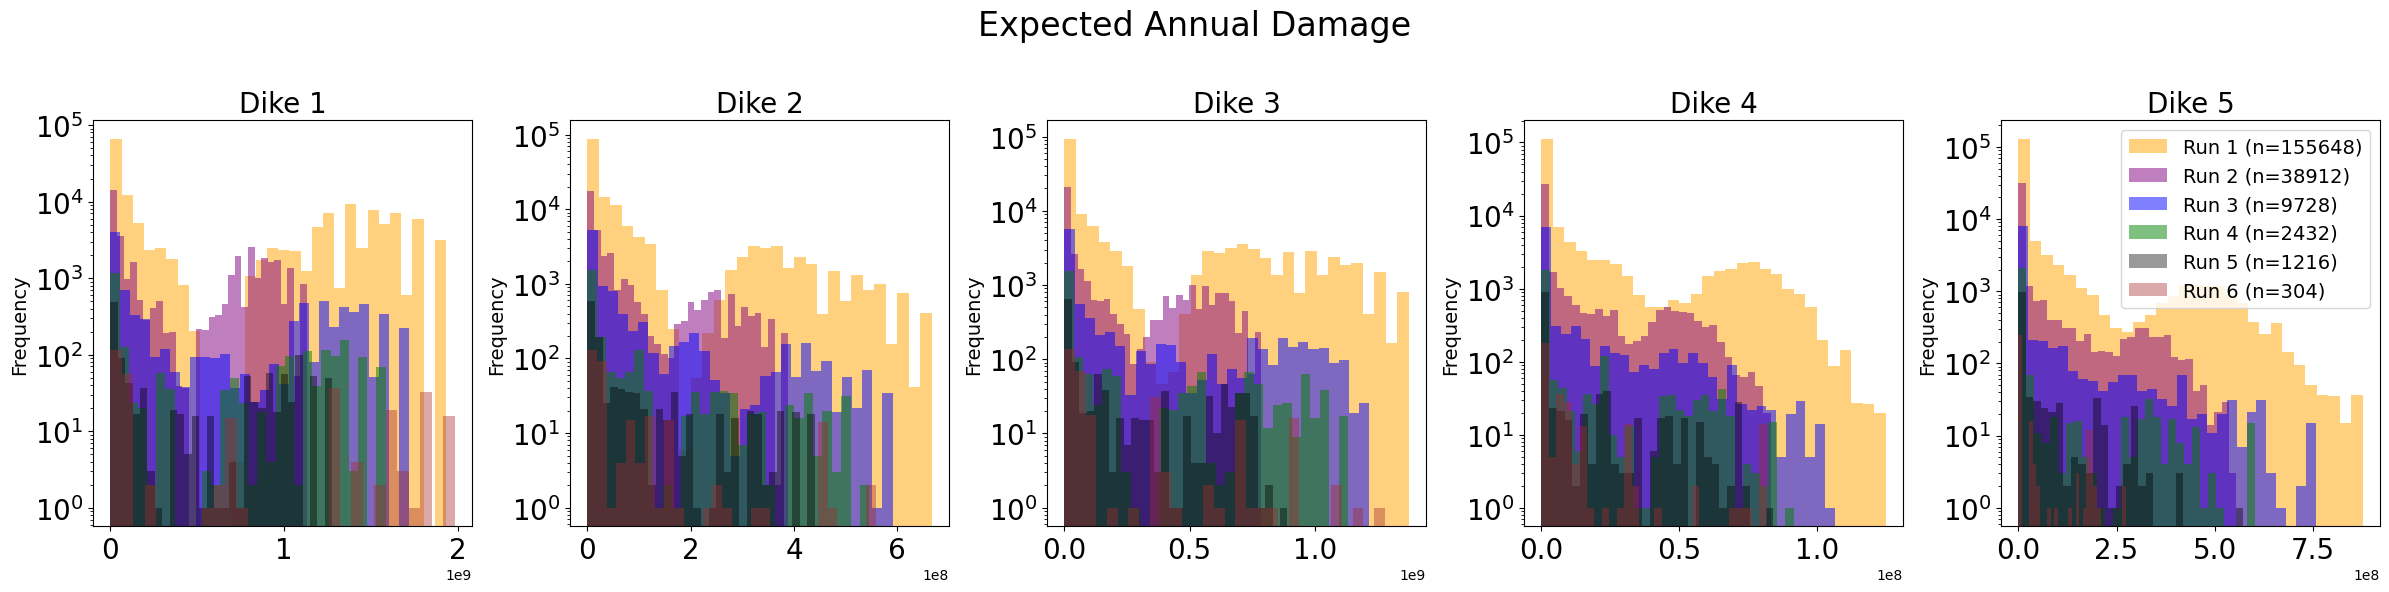

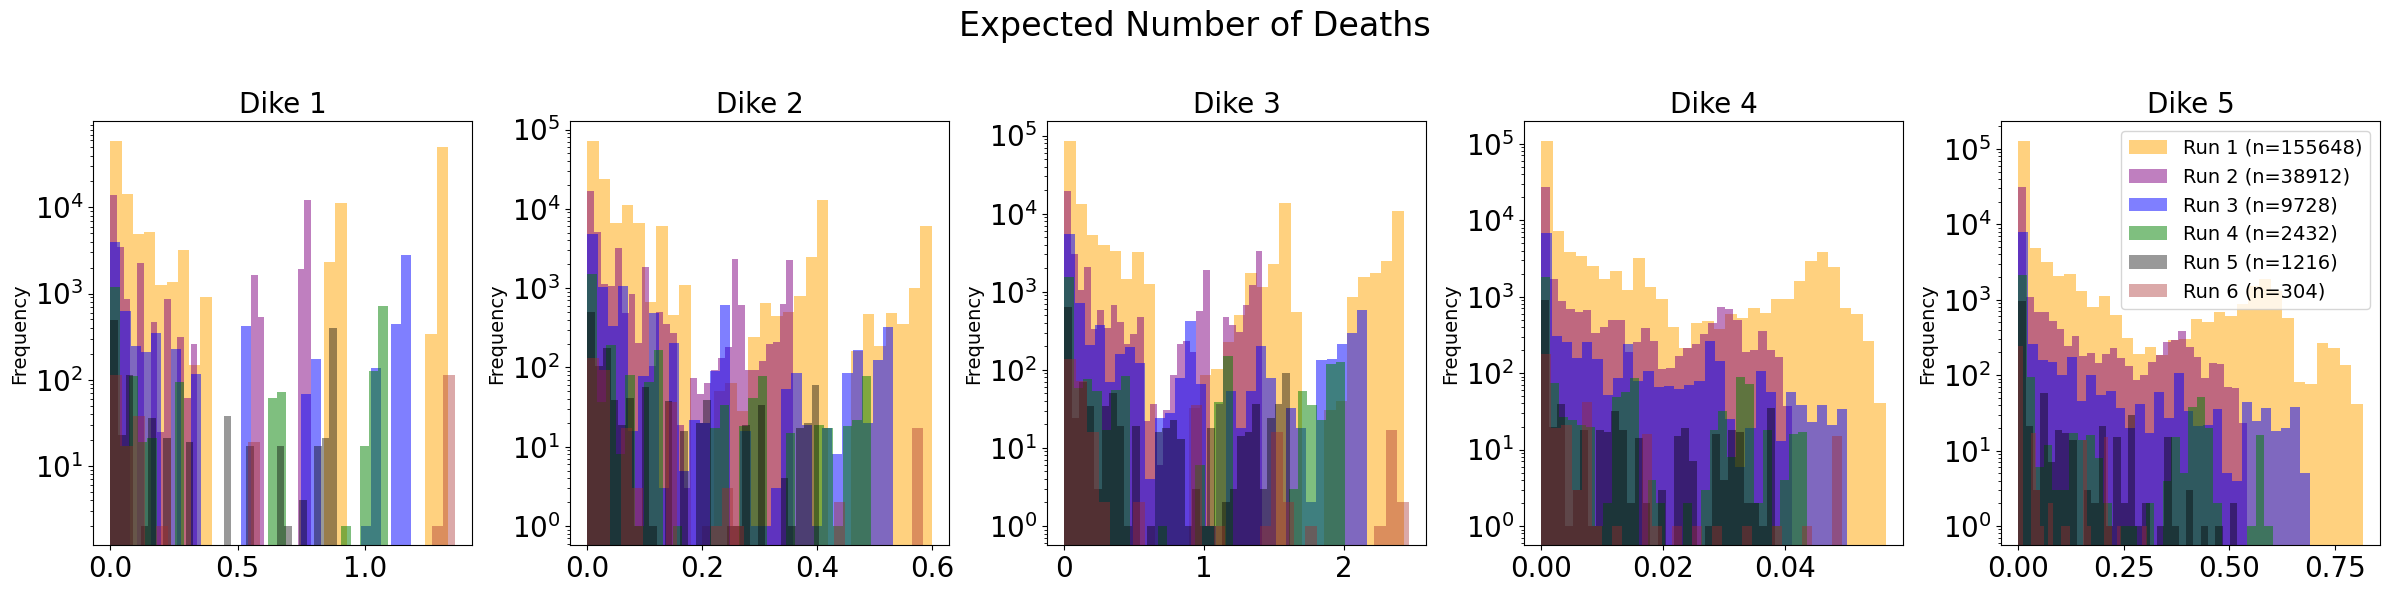

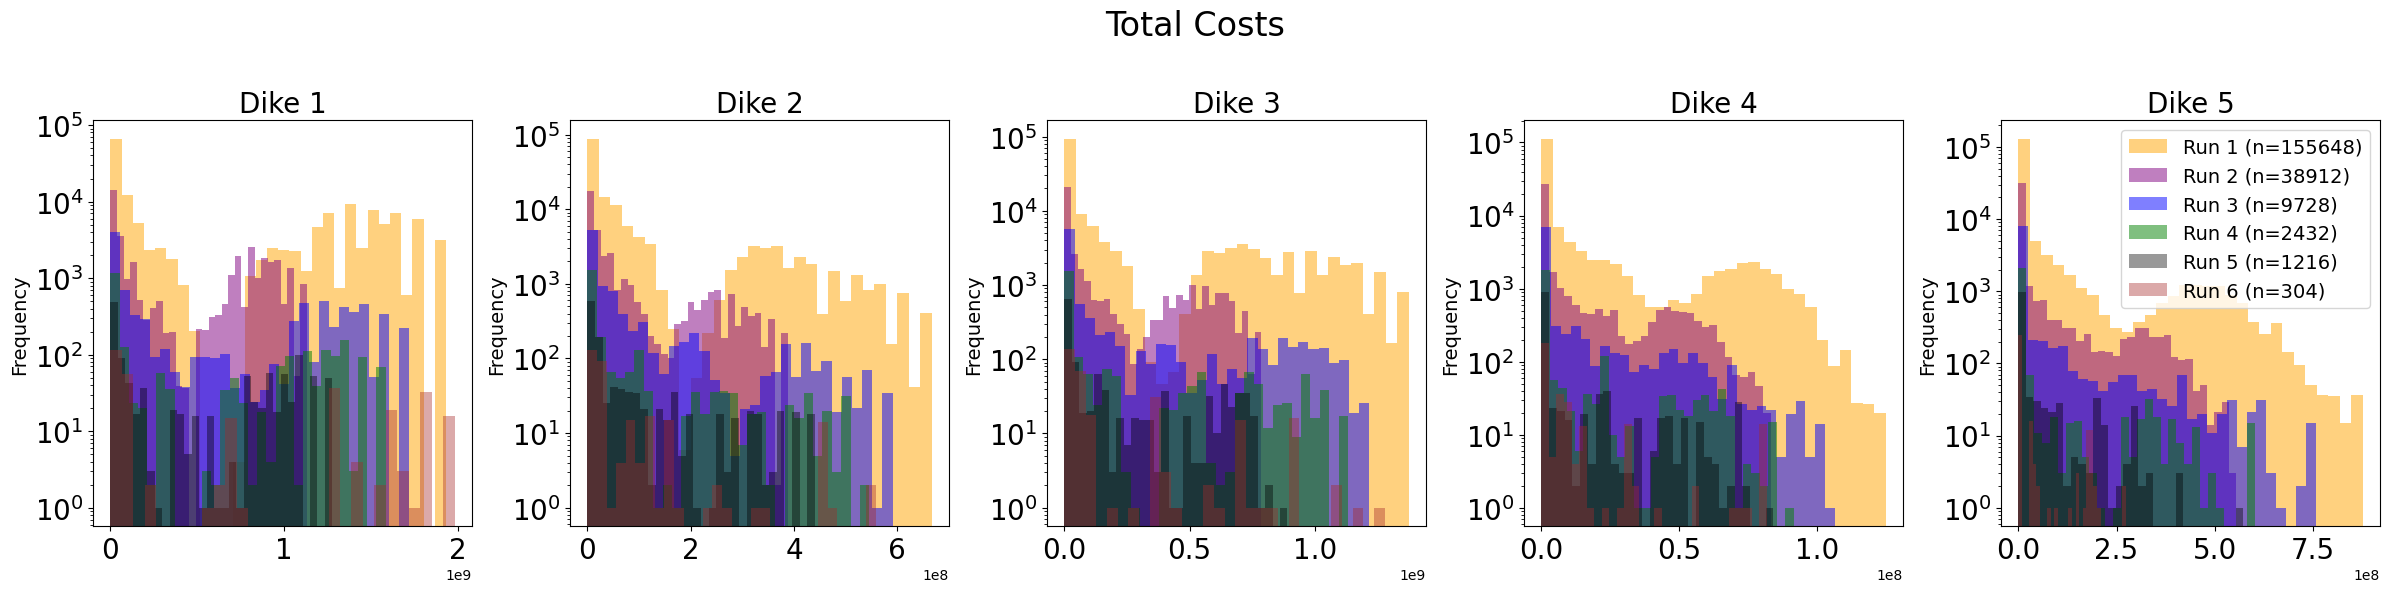

Figure 2: Histograms of disaggregated outcomes for all dikes, comparing 6 runs, in log scale.


In [5]:
## Histogram plot - log scale

disaggregated_outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs"]

# Plot histograms for each disaggregated outcome for all dikes, comparing two runs
for outcome_name in disaggregated_outcome_names:
    fig, axes = plt.subplots(1, 5, figsize=(24, 6))
    for i, dike_no in enumerate(range(1, 6)):
        key = f"A.{dike_no}_{outcome_name}"
        axes[i].hist(outcomes_1[key], bins=30, color='orange', edgecolor='none', alpha=0.5, label=f'Run 1 (n={experiments_1.shape[0]})')
        axes[i].hist(outcomes_2[key], bins=30, color='purple', edgecolor='none', alpha=0.5, label=f'Run 2 (n={experiments_2.shape[0]})')
        axes[i].hist(outcomes_3[key], bins=30, color='blue', edgecolor='none', alpha=0.5, label=f'Run 3 (n={experiments_3.shape[0]})')
        axes[i].hist(outcomes_4[key], bins=30, color='green', edgecolor='none', alpha=0.5, label=f'Run 4 (n={experiments_4.shape[0]})')
        axes[i].hist(outcomes_5[key], bins=30, color='black', edgecolor='none', alpha=0.4, label=f'Run 5 (n={experiments_5.shape[0]})')
        axes[i].hist(outcomes_6[key], bins=30, color='brown', edgecolor='none', alpha=0.4, label=f'Run 6 (n={experiments_6.shape[0]})')
        axes[i].set_title(f"Dike {dike_no}", fontsize=20)
        axes[i].set_ylabel("Frequency", fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=20)
        axes[i].set_yscale('log')
        if i == 4:
            axes[i].legend(fontsize=14)
    fig.suptitle(f"{outcome_name}", fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("Figure 2: Histograms of disaggregated outcomes for all dikes, comparing 6 runs, in log scale.")

**Discussion**

We ran the model six times, each with a different number of scenarios sampled from the uncertainty space. Figures 1 and 2 show the distributions of key outcomes, using normal and log scales.

Figure 1 (normal scale) shows that, without any flood prevention policy, dikes A.4 (Gorssel) and A.5 (Deventer) rarely experience flooding, while the upstream dikes (A.1–A.3) are much more affected by uncertainties. When using a small number of scenarios (Runs 4–6), the analysis misses rare but severe outcomes for some dikes, making the results overly optimistic. This suggests that using too few scenarios is not reliable for robust policy analysis.

Figure 2 (log scale) helps us see the full range of possible outcomes, including rare extreme events. Runs 1–3, which use more scenarios, consistently capture a wider range of outcomes. Notably, Run 3 achieves good coverage of extreme cases with far fewer scenarios than Run 1, making it a more efficient choice.

Based on these results, we chose to use the smaller set of scenarios (about 9,000 in Run 3). This set provides a good balance between capturing rare events and keeping computational costs reasonable.

### Compare two runs (with the same number of scenarios)

To ensure our analysis is reliable, it’s important that the scenarios we use actually reflect the full range of possible futures for the system. In this project, there are many uncertainties—meaning there are countless ways the future could unfold. However, running simulations for every possible combination would take too much time and computing power. Instead, we selected about 9,000 scenarios to represent the uncertainty space.

But how do we know if these 9,000 scenarios are truly representative? To check this, we repeated the process: we ran the simulation twice, each time drawing a new set of 9,000+ scenarios using the same sampling method. By comparing the results from these two runs, we can see if the key outcomes (like damages, deaths, and costs) are similar. If the results are consistent, it suggests that our sample is large enough and captures the important variations in the system. If not, we might need to use more scenarios or adjust our sampling approach. This comparison helps us build confidence that our policy analysis is based on a solid foundation.

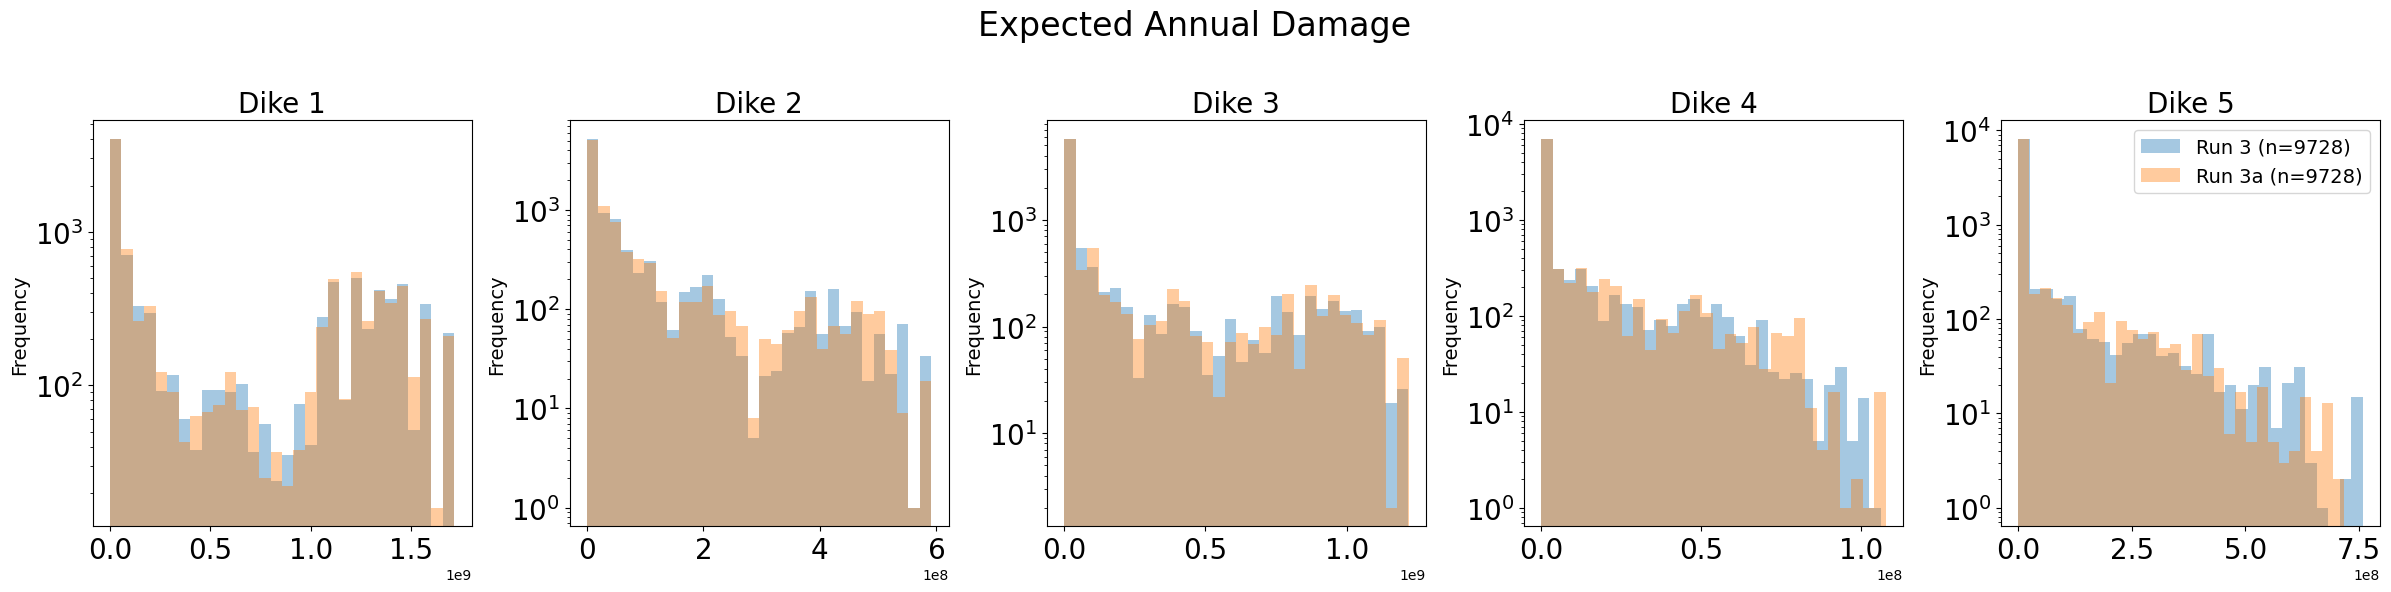

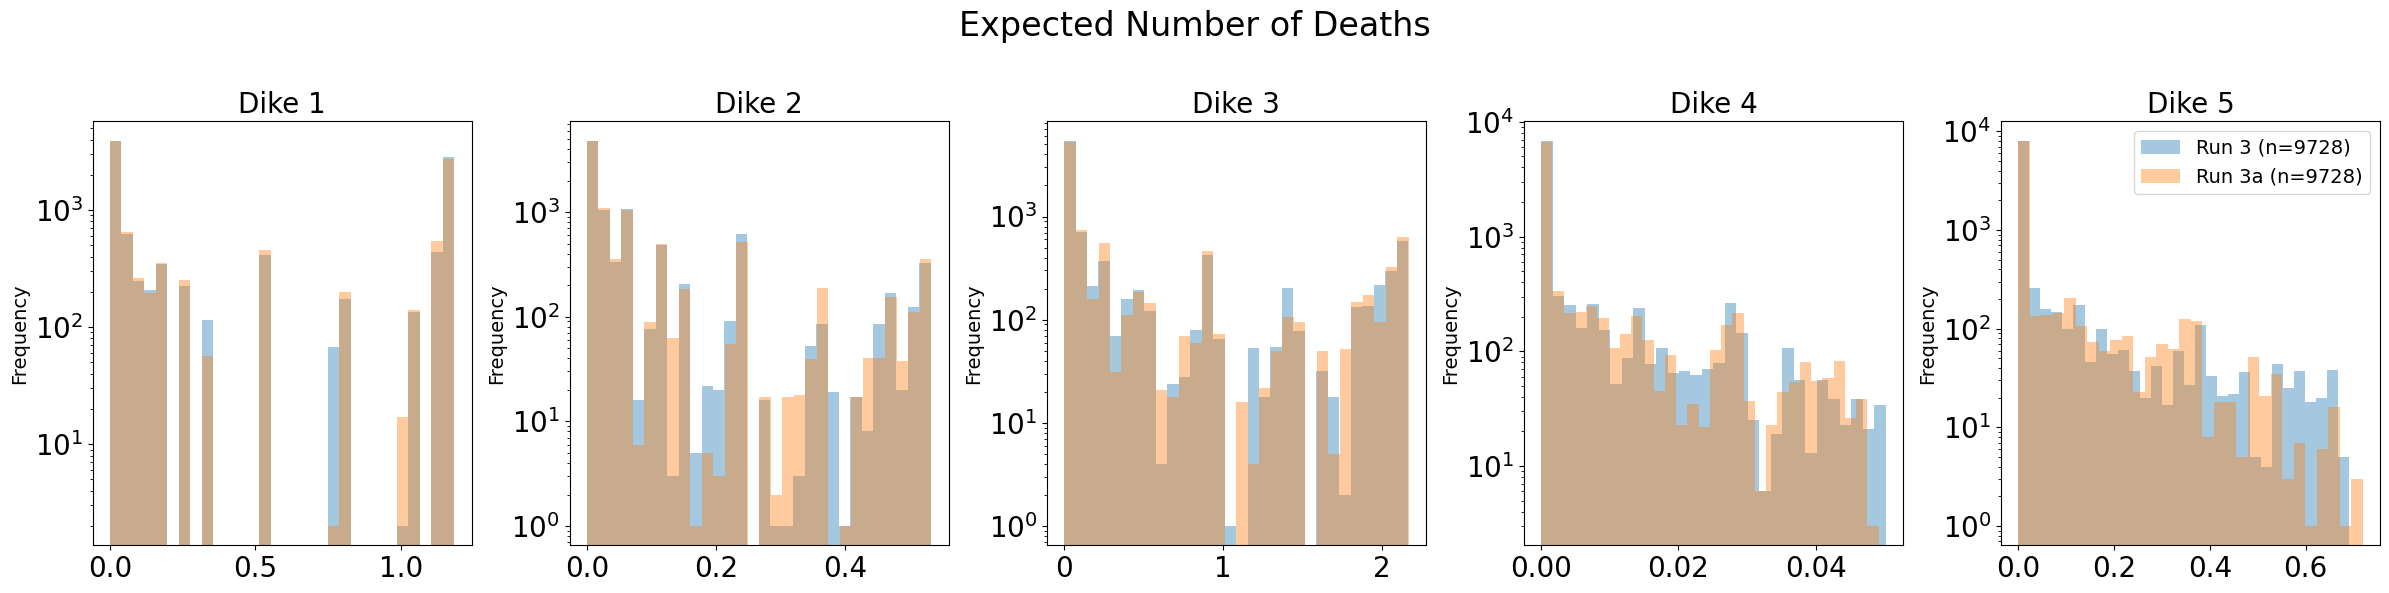

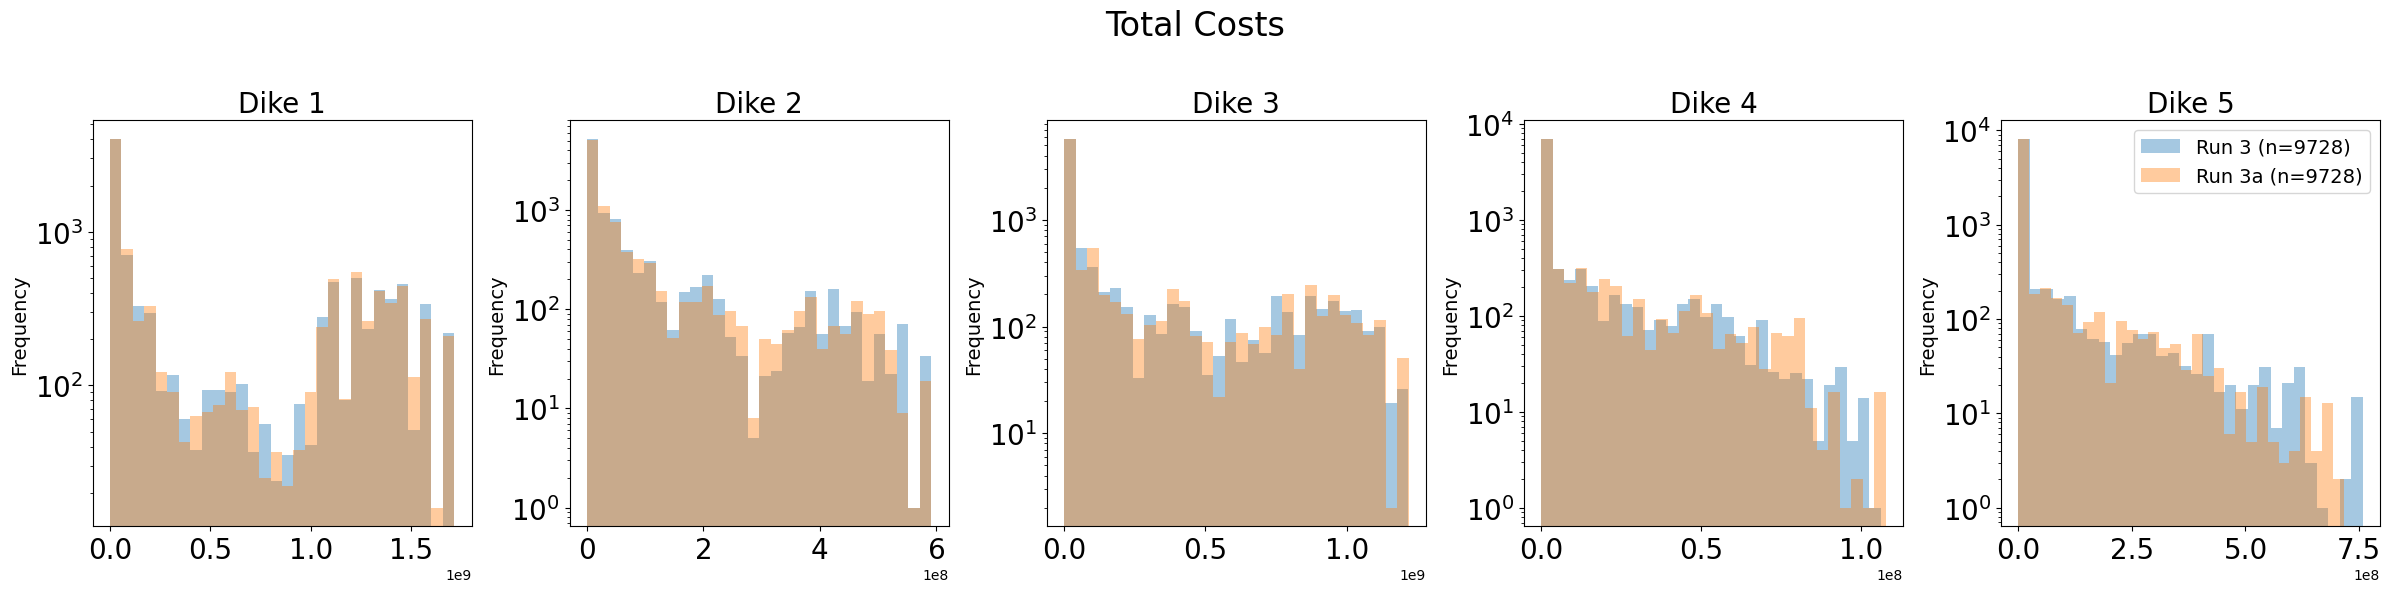

Figure 3: Histograms of outcomes, comparing two runs that contain 9728 scenarios, in log scale.


In [6]:
## Histogram plot - log scale

disaggregated_outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs"]
colors = ['#1f77b4', '#ff7f0e']  # Custom colors for Run 3 and Run 3a

# Plot histograms for each disaggregated outcome for all dikes, comparing two runs
for outcome_name in disaggregated_outcome_names:
    fig, axes = plt.subplots(1, 5, figsize=(24, 6))
    for i, dike_no in enumerate(range(1, 6)):
        key = f"A.{dike_no}_{outcome_name}"
        axes[i].hist(outcomes_3[key], bins=30, color=colors[0], edgecolor='none', alpha=0.4, label=f'Run 3 (n={experiments_3.shape[0]})')
        axes[i].hist(outcomes_3a[key], bins=30, color=colors[1], edgecolor='none', alpha=0.4, label=f'Run 3a (n={experiments_3a.shape[0]})')
        axes[i].set_title(f"Dike {dike_no}", fontsize=20)
        axes[i].set_ylabel("Frequency", fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=20)
        axes[i].set_yscale('log')
        if i == 4:
            axes[i].legend(fontsize=14)
    fig.suptitle(f"{outcome_name}", fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("Figure 3: Histograms of outcomes, comparing two runs that contain 9728 scenarios, in log scale.")

In [7]:
# Compare summary statistics for each outcome and dike (1-5)
summary_stats = []

for outcome_name in disaggregated_outcome_names:
    for dike_no in range(1, 6):
        key = f"A.{dike_no}_{outcome_name}"
        data1 = outcomes_3[key]
        data2 = outcomes_3a[key]
        stats = {
            'Outcome': f"Dike {dike_no} - {outcome_name}",
            'Run 1 Mean': np.mean(data1),
            'Run 2 Mean': np.mean(data2),
            'Mean Diff %': 100 * (np.mean(data2) - np.mean(data1)) / np.mean(data1) if np.mean(data1) != 0 else np.nan,
            'Run 1 Median': np.median(data1),
            'Run 2 Median': np.median(data2),
            'Median Diff %': 100 * (np.median(data2) - np.median(data1)) / np.median(data1) if np.median(data1) != 0 else np.nan,
            'Run 1 Std': np.std(data1),
            'Run 2 Std': np.std(data2),
            'Std Diff %': 100 * (np.std(data2) - np.std(data1)) / np.std(data1) if np.std(data1) != 0 else np.nan,
            'Run 1 5th %ile': np.percentile(data1, 5),
            'Run 2 5th %ile': np.percentile(data2, 5),
            '5th %ile Diff %': 100 * (np.percentile(data2, 5) - np.percentile(data1, 5)) / np.percentile(data1, 5) if np.percentile(data1, 5) != 0 else np.nan,
            'Run 1 95th %ile': np.percentile(data1, 95),
            'Run 2 95th %ile': np.percentile(data2, 95),
            '95th %ile Diff %': 100 * (np.percentile(data2, 95) - np.percentile(data1, 95)) / np.percentile(data1, 95) if np.percentile(data1, 95) != 0 else np.nan,
        }
        summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
pd.set_option('display.float_format', '{:.3g}'.format)
#display(summary_df)

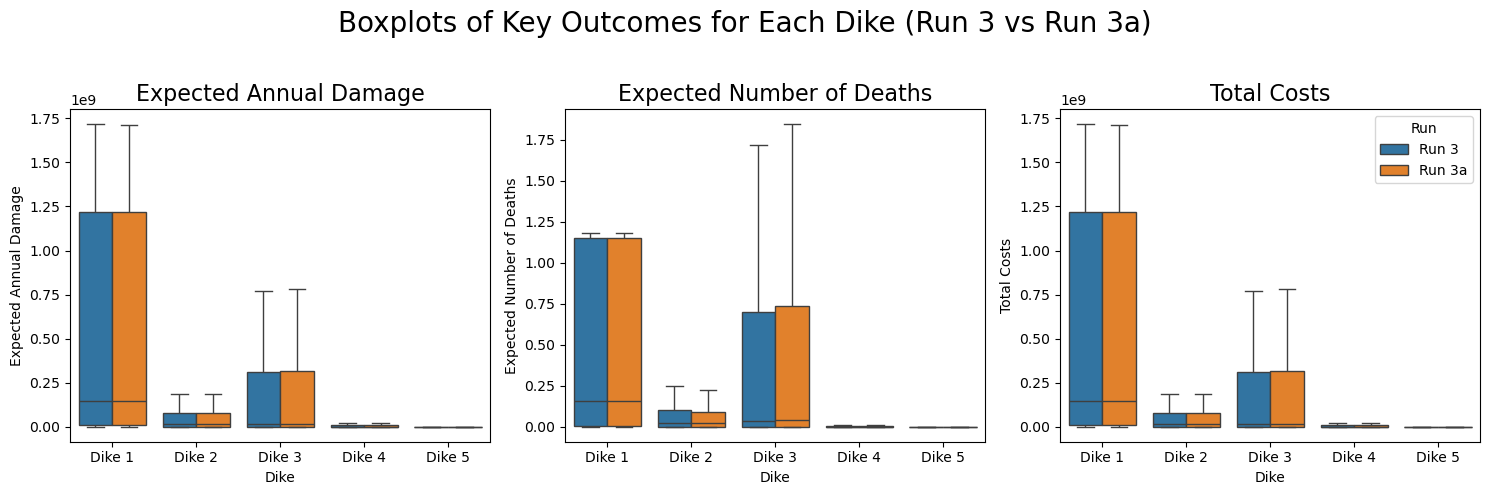

Figure 4: Boxplots of key outcomes for each dike, comparing Run 3 and Run 3a.


In [8]:
# Box plots for each key outcome and dike, comparing Run 3 and Run 3a, in a single row of 3 subplots

disaggregated_outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs"]
dike_labels = [f"Dike {i}" for i in range(1, 6)]
colors = ['#1f77b4', '#ff7f0e']  # Custom colors for Run 3 and Run 3a

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

for idx, outcome_name in enumerate(disaggregated_outcome_names):
    data = []
    for dike_no in range(1, 6):
        key = f"A.{dike_no}_{outcome_name}"
        data1 = outcomes_3[key]
        data2 = outcomes_3a[key]
        # Add data for Run 3
        data.append(pd.DataFrame({
            "Value": data1,
            "Dike": dike_labels[dike_no-1],
            "Run": "Run 3"
        }))
        # Add data for Run 3a
        data.append(pd.DataFrame({
            "Value": data2,
            "Dike": dike_labels[dike_no-1],
            "Run": "Run 3a"
        }))
    df = pd.concat(data, ignore_index=True)
    sns.boxplot(
        x="Dike", y="Value", hue="Run", data=df, showfliers=False, ax=axes[idx],
        palette=colors
    )
    axes[idx].set_title(f"{outcome_name}", fontsize=16)
    axes[idx].set_ylabel(outcome_name)
    if idx == 2:
        axes[idx].legend(title="Run")
    else:
        axes[idx].get_legend().remove()
    #axes[idx].set_yscale('log')

plt.suptitle("Boxplots of Key Outcomes for Each Dike (Run 3 vs Run 3a)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("Figure 4: Boxplots of key outcomes for each dike, comparing Run 3 and Run 3a.")

**Discussion**

The comparison between two runs ...

Compare summary statistics

* Compute and compare means, medians, standard deviations, and percentiles (e.g., 5th, 50th, 95th) for each outcome.
* Small differences between runs indicate stability.

## 2 Sensitivity Analysis

Sensitivity analysis helps us understand which uncertainties have the greatest impact on model outcomes. By systematically varying uncertain parameters and observing changes in key results, we can identify the most influential factors driving system behavior. This insight guides decision makers in prioritizing data collection, refining models, and focusing policy interventions on the most critical sources of uncertainty. In this section, we will use global sensitivity analysis techniques (such as Sobol indices) to quantify the contribution of each uncertainty to the variance in important outcomes.

## 3 Scenario Discovery

Scenario discovery is a process used to identify and characterize regions of the uncertainty space that are associated with particularly challenging or interesting outcomes. By systematically analyzing simulation results, we can uncover combinations of uncertain factors that lead to policy-relevant cases—such as system failures, high costs, or unacceptable risks. This enables decision makers to focus their attention and resources on the most critical scenarios, supporting robust policy design and targeted risk management. In this section, we will apply scenario discovery techniques (such as Patient Rule Induction Method, PRIM) to highlight and interpret these key regions of interest within the broader set of simulated futures.

### Define interesting scenarios

* **Best-case:** Scenario(s) with the zero expected deaths and minimum total cost for all three outcomes for dikes 4 and 5 (or as close to zero as possible).

* **Mediocre-case:** Scenario(s) near 80th percentile of the distribution for all three outcomes for dikes 4 and 5.

* **Worst-case:** Scenario(s) near the 99th percentile (or maximum) for all three outcomes for dikes 4 and 5.

In [9]:
experiments, outcomes = results_3

In [10]:
# drop levers
experiments.drop(columns=list(model.levers.keys()), inplace=True, errors='ignore')
experiments.drop(columns=["policy", "scenario", "model"], inplace=True, errors='ignore')

In [11]:
def find_best_case(experiments, outcomes, tol=1e-8):
    dikes = [4, 5]
    # First, find scenarios with zero Expected Number of Deaths for all dikes
    deaths_zero = np.ones(len(experiments), dtype=bool)
    for d in dikes:
        key = f"A.{d}_Expected Number of Deaths"
        deaths_zero &= np.isclose(outcomes[key], 0, atol=tol)
    # Among those, find the minimum sum of Total Costs
    outcome_names = ["Total Costs"]
    total_costs = np.zeros(len(experiments))
    for d in dikes:
        for o in outcome_names:
            total_costs += outcomes[f"A.{d}_{o}"]
    # Only consider scenarios with zero deaths
    filtered_costs = np.where(deaths_zero, total_costs, np.inf)
    min_sum = np.min(filtered_costs)
    y = np.isclose(filtered_costs, min_sum, atol=tol)
    return y

def find_case_near_percentile(experiments, outcomes, percentile=99, tol=1e-8):
    dikes = [4, 5]
    outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs"]
    percentiles = {}
    for d in dikes:
        for o in outcome_names:
            key = f"A.{d}_{o}"
            percentiles[key] = np.percentile(outcomes[key], percentile)
    dists = np.zeros(len(experiments))
    for i in range(len(experiments)):
        dist = 0
        for d in dikes:
            for o in outcome_names:
                key = f"A.{d}_{o}"
                dist += abs(outcomes[key][i] - percentiles[key])
        dists[i] = dist
    min_dist = np.min(dists)
    y = np.isclose(dists, min_dist, atol=tol)
    return y

def find_worst_case_by_percentile(experiments, outcomes, percentile=99, tol=1e-8):
    dikes = [4, 5]
    outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs"]
    y = np.ones(len(experiments), dtype=bool)
    for d in dikes:
        for o in outcome_names:
            key = f"A.{d}_{o}"
            thresh = np.percentile(outcomes[key], percentile)
            y &= outcomes[key] >= (thresh - tol)
    return y

# Find best, mediocre, and worst cases based on the defined criteria
y_best_case = find_best_case(experiments, outcomes)
y_mediocre_case = find_case_near_percentile(experiments, outcomes, percentile=65)
y_worst_case = find_worst_case_by_percentile(experiments, outcomes, percentile=65)


In [12]:
# count the number of True values in each case
print(f"Best case: {np.sum(y_best_case)} scenarios")
print(f"Mediocre case: {np.sum(y_mediocre_case)} scenarios")
print(f"Worst case: {np.sum(y_worst_case)} scenarios")


Best case: 4803 scenarios
Mediocre case: 1 scenarios
Worst case: 3403 scenarios


### Discover best-case scenarios using PRIM

[MainProcess/INFO] 9728 points remaining, containing 4803 cases of interest
[MainProcess/INFO] mean: 0.9962406015037594, mass: 0.0546875, coverage: 0.11034769935457006, density: 0.9962406015037594 restricted_dimensions: 14


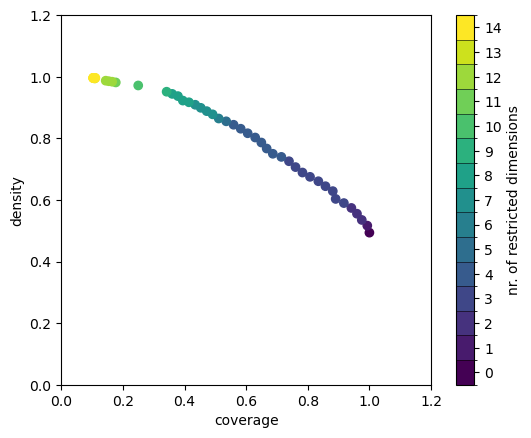

[<Figure size 640x480 with 1 Axes>]

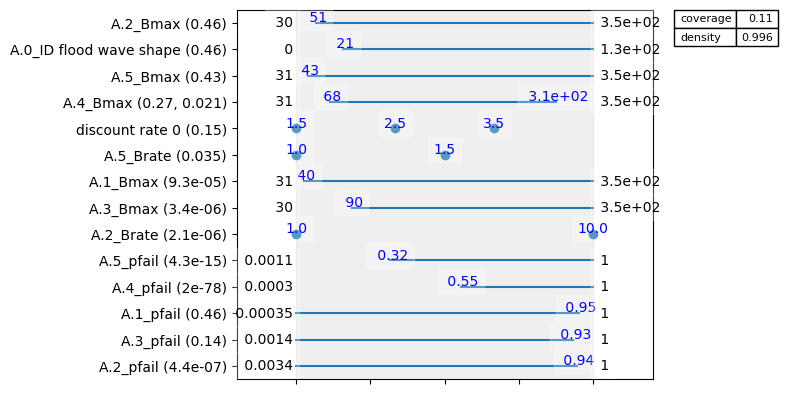

In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from ema_workbench.analysis import prim

prim_alg = prim.Prim(experiments, y_best_case, threshold=0.8)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

box1.inspect(style='graph')

### Discover worst-case scenarios using PRIM

[MainProcess/INFO] 9728 points remaining, containing 3403 cases of interest


[MainProcess/INFO] mean: 1.0, mass: 0.06291118421052631, coverage: 0.179841316485454, density: 1.0 restricted_dimensions: 8


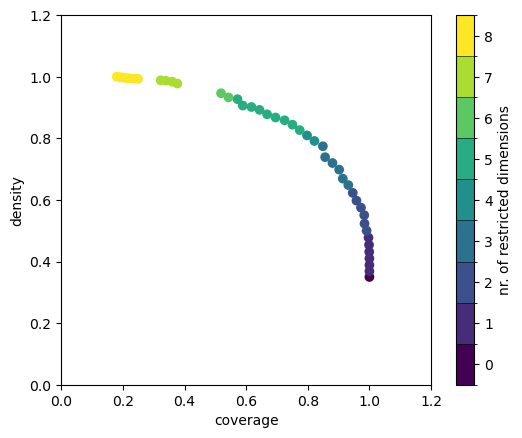

[<Figure size 640x480 with 1 Axes>]

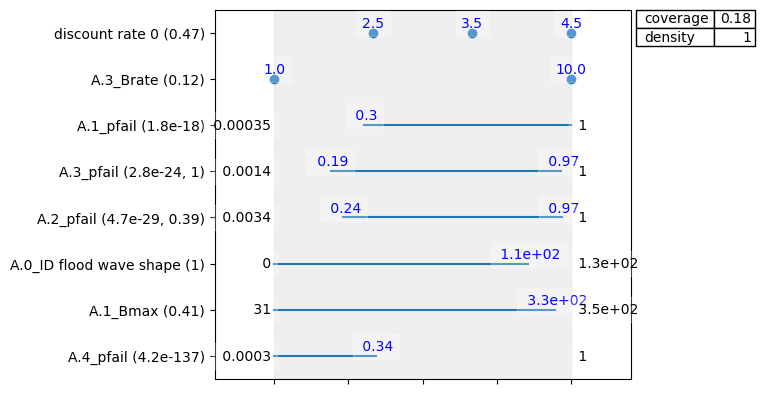

In [14]:
prim_alg = prim.Prim(experiments, y_worst_case, threshold=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

box1.inspect(style='graph')

In [23]:
# Randomly select one best case, one mediocre case, and one worst case for further analysis
best_case_indices = np.where(y_best_case)[0]
mediocre_case_indices = np.where(y_mediocre_case)[0]
worst_case_indices = np.where(y_worst_case)[0]

np.random.seed(789)
best_case_index = np.random.choice(best_case_indices)
mediocre_case_index = np.random.choice(mediocre_case_indices)
worst_case_index = np.random.choice(worst_case_indices)

# Extract the experiments
best_case_experiment = experiments.iloc[best_case_index]
mediocre_case_experiment = experiments.iloc[mediocre_case_index]
worst_case_experiment = experiments.iloc[worst_case_index]

# Extract the outcomes for each case
best_case_outcomes = {k: v[best_case_index] for k, v in outcomes.items()}
mediocre_case_outcomes = {k: v[mediocre_case_index] for k, v in outcomes.items()}
worst_case_outcomes = {k: v[worst_case_index] for k, v in outcomes.items()}

'''# Print the cases
print("Best Case Experiment:")
print(best_case_experiment)
print("\nBest Case Outcomes:")
print(best_case_outcomes)

print("\nMediocre Case Experiment:")
print(mediocre_case_experiment)
print("\nMediocre Case Outcomes:")
print(mediocre_case_outcomes)

print("\nWorst Case Experiment:")
print(worst_case_experiment)
print("\nWorst Case Outcomes:")
print(worst_case_outcomes)'''

# Combine experiments and outcomes for each case into a DataFrame
def case_to_df(exp, out, case_name):
    exp_df = exp.to_frame().T if isinstance(exp, pd.Series) else pd.DataFrame([exp])
    out_df = pd.DataFrame([out])
    df = pd.concat([exp_df.reset_index(drop=True), out_df.reset_index(drop=True)], axis=1)
    df.insert(0, "Case", case_name)
    return df

df_best = case_to_df(best_case_experiment, best_case_outcomes, "Best")
df_mediocre = case_to_df(mediocre_case_experiment, mediocre_case_outcomes, "Mediocre")
df_worst = case_to_df(worst_case_experiment, worst_case_outcomes, "Worst")

cases_df = pd.concat([df_best, df_mediocre, df_worst], ignore_index=True)
cases_df

,Case,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.4_Total Costs,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Total Costs,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,Best,51,201,10,0.721,344,10,0.361,113,1.5,...,0,0,0,0,0,0,0,0,0,0
1,Mediocre,40,242,1.5,0.00803,80,1.5,0.358,157,10,...,1.08e+06,0,1.08e+06,0.000714,0,0,0,0,0,0
2,Worst,89,221,10,0.852,83.5,1,0.643,304,1.5,...,4.26e+07,0,4.26e+07,0.0254,0,0,0,0,0,0


In [24]:
# Save the selected cases to a CSV file
cases_df.to_csv("selected_cases.csv", index=False)